# Exploratory data analysis (EDA)

**Загрузка и ознакомление с данными**

In [ ]:
import pandas as pd
import numpy as np
import math
import statsmodels.stats.api as sms
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pylab
from datetime import datetime
from enum import auto

Загрузим таблицы




In [ ]:
#таблица abtest
abtest = pd.read_csv('/content/abtest.csv')



In [ ]:
#таблица private
private = pd.read_csv('/content/private.csv')
private['Date'] = pd.to_datetime(private['Date'], format='%d/%m/%Y')


In [ ]:
#Объединяем их по user_id
df = pd.merge(abtest, private,
                   on='user_id',
                   how='inner')
print(df)
df.info()

    user_id      group landing_page  time_spent_on_the_page converted  \
0    546592    control          old                    3.48        no   
1    546468  treatment          new                    7.13       yes   
2    546462  treatment          new                    4.40        no   
3    546567    control          old                    3.02        no   
4    546459  treatment          new                    4.75       yes   
..      ...        ...          ...                     ...       ...   
95   546446  treatment          new                    5.15        no   
96   546544    control          old                    6.52       yes   
97   546472  treatment          new                    7.07       yes   
98   546481  treatment          new                    6.20       yes   
99   546483  treatment          new                    5.86       yes   

   language_preferred       Date    sex  age  
0             Spanish 2024-11-01    man   29  
1             English 2024-11

Теперь у нас есть информация private о поле и возрасте пользователей, а так же о дате посещения сайта.


In [ ]:
#проверяем отстутсвующие значения
df.isnull().sum()

,0
user_id,0
group,0
landing_page,0
time_spent_on_the_page,0
converted,0
language_preferred,0
Date,0
sex,0
age,0


In [ ]:
#проверяем наличие дубликатов
df.duplicated().sum()

0

In [ ]:
group_counter = df.groupby('user_id')['group'].nunique()
print('Number of users in both groups: %d' % len(group_counter[group_counter>1].index))
print('% of users in both groups: {:.2%}'.format(len(group_counter[group_counter>1].index)/df['user_id'].nunique()))

Number of users in both groups: 0
% of users in both groups: 0.00%


Univariate Analysis

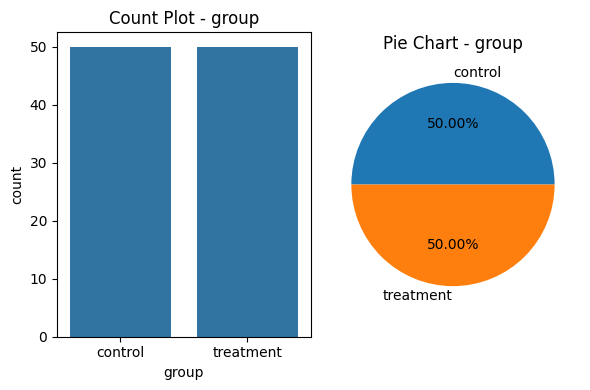

In [ ]:
#проверим численность групп
variable = 'group'

plt.figure(figsize=(6,4))

plt.subplot(1,2,1)
sns.countplot(x=variable, data=df)
plt.title(f'Count Plot - {variable}')

plt.subplot(1,2,2)
counts = df[variable].value_counts()
plt.pie(counts, labels=counts.index, autopct='%0.2f%%')
plt.title(f'Pie Chart - {variable}')

plt.tight_layout()
plt.show()

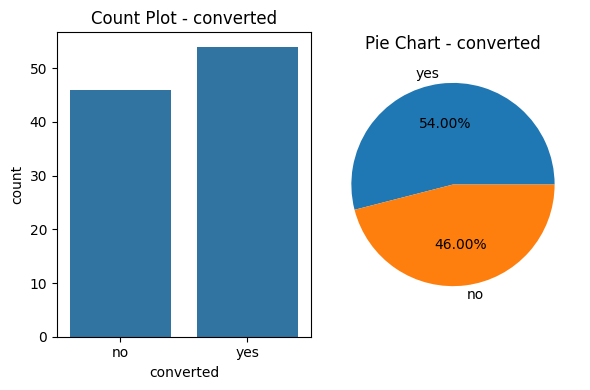

In [ ]:
#суммарное соотношение перешедших и не перешедших на сайт людей
variable = 'converted'

plt.figure(figsize=(6,4))

plt.subplot(1,2,1)
sns.countplot(x=variable, data=df)
plt.title(f'Count Plot - {variable}')

plt.subplot(1,2,2)
counts = df[variable].value_counts()
plt.pie(counts, labels=counts.index, autopct='%0.2f%%')
plt.title(f'Pie Chart - {variable}')

plt.tight_layout()

plt.show()



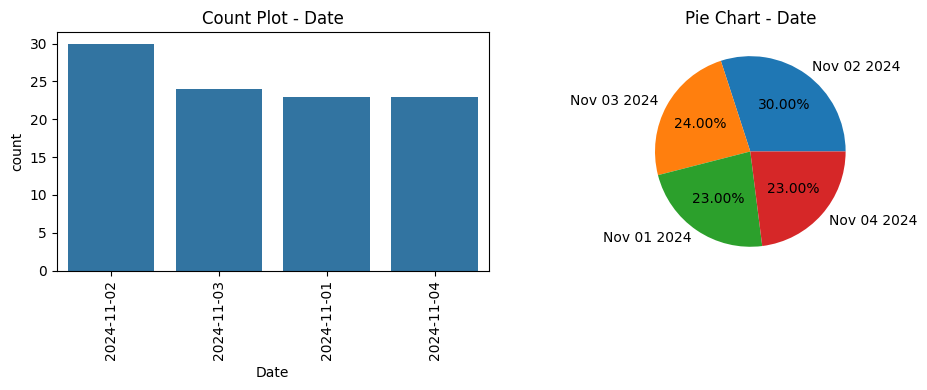

In [ ]:
#количество просмотров по дням
variable = 'Date'

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.countplot(x=variable, data=df, order=df['Date'].value_counts().index)
plt.title(f'Count Plot - {variable}')
plt.xticks(rotation=90)

plt.subplot(1,2,2)

counts = df[variable].value_counts()
plt.pie(counts, labels=counts.index.strftime('%b %d %Y'), autopct='%0.2f%%')
plt.title(f'Pie Chart - {variable}')

plt.tight_layout()

plt.show()


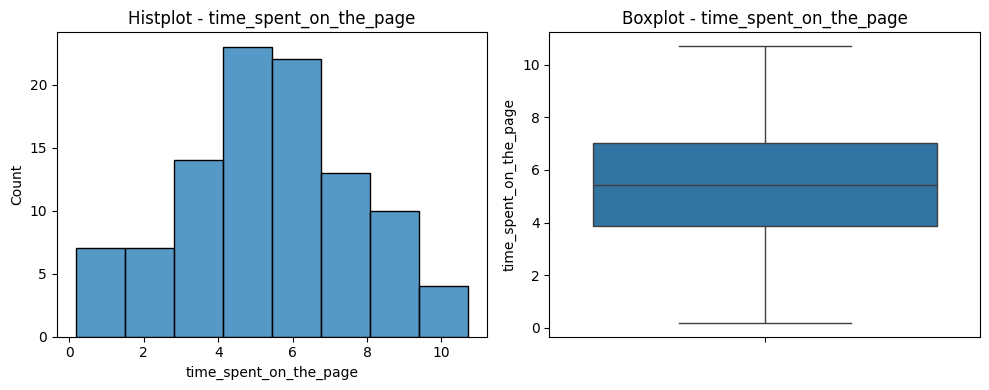

In [ ]:
#посмотрим на распределение данных о времени проведенное пользователями на страничке
variable = 'time_spent_on_the_page'

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.histplot(data=df,x='time_spent_on_the_page')
plt.title(f'Histplot - {variable}')

plt.subplot(1,2,2)
sns.boxplot(y=variable, data = df)
plt.title(f'Boxplot - {variable}')

plt.tight_layout()

plt.show()


In [ ]:
#основные показатели данных о времени
df['time_spent_on_the_page'].describe()

,time_spent_on_the_page
count,100.000000
mean,5.377800
std,2.378166
min,0.190000
25%,3.880000
50%,5.415000
75%,7.022500
max,10.710000


Bivariate Analysis

In [ ]:
#посчитаем конверсию в разных группах
ct_conversion_group = pd.crosstab(df['group'], df['converted'], normalize='index')
ct_conversion_group.value_counts()


,,count
no,yes,
0.34,0.66,1
0.58,0.42,1


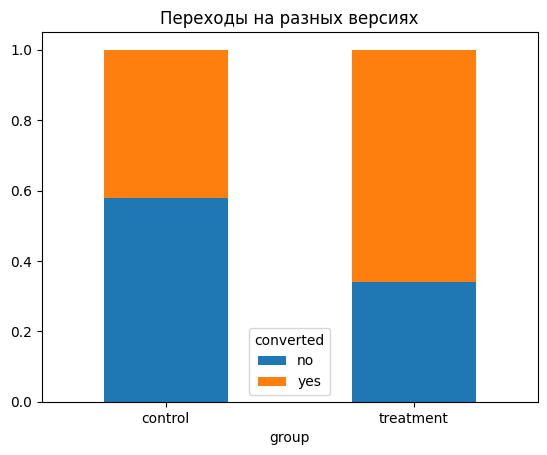

In [ ]:
#сравниваем количество переходов на разных версиях сайта
ct_conversion_group.plot.bar(stacked=True)
plt.xticks(rotation=0)
plt.title("Переходы на разных версиях")
plt.show()

In [ ]:
#расчитаем количество перешедших на сайт людей
mask = df['converted'] == 'yes'

conv = df[mask].groupby('group')['converted'].count()
conv

,converted
group,
control,21
treatment,33


In [ ]:
#формируем данные конверсии по дням в разных группах
mask_old = (df['landing_page'] == 'old') & (df['converted'] == 'yes')
old_conv_by_day = df[mask_old].groupby('Date')['converted'].count()

mask_new = (df['landing_page'] == 'new') & (df['converted'] == 'yes')
new_conv_by_day = df[mask_new].groupby('Date')['converted'].count()

print(new_conv_by_day, old_conv_by_day)


Date
2024-11-01     8
2024-11-02     7
2024-11-03    11
2024-11-04     7
Name: converted, dtype: int64 Date
2024-11-01    5
2024-11-02    6
2024-11-03    8
2024-11-04    2
Name: converted, dtype: int64


In [ ]:
#Смотрим соотношение переходов в группах
mask_old_no = (df['landing_page'] == 'old') & (df['converted'] == 'no')
mask_new_no = (df['landing_page'] == 'new') & (df['converted'] == 'no')

old_yes_conv = df[mask_old]['converted'].count()
old_no_conv = df[mask_old_no]['converted'].count()
new_yes_conv = df[mask_new]['converted'].count()
new_no_conv = df[mask_new_no]['converted'].count()
old_yes_conv,old_no_conv

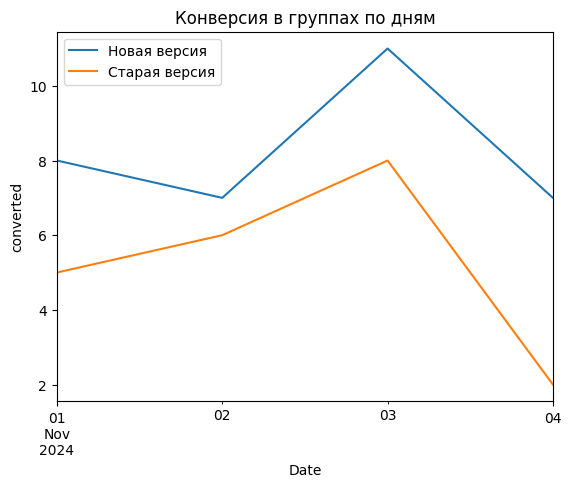

In [ ]:
#строим графики конверсии в группах по дням
ax = plt.gca()
new_conv_by_day.plot(x = df['Date'], y = df['converted'])
old_conv_by_day.plot(x = df['Date'], y = df['converted'], title="Конверсия в группах по дням")

ax.set_ylabel('converted')
plt.legend(labels=["Новая версия", "Старая версия"])
plt.show()


In [ ]:
#вычислим суммарное время просмотров на разных версиях сайта
sum_time = df.groupby('group')['time_spent_on_the_page'].sum()
sum_time

,time_spent_on_the_page
group,
control,226.62
treatment,311.16


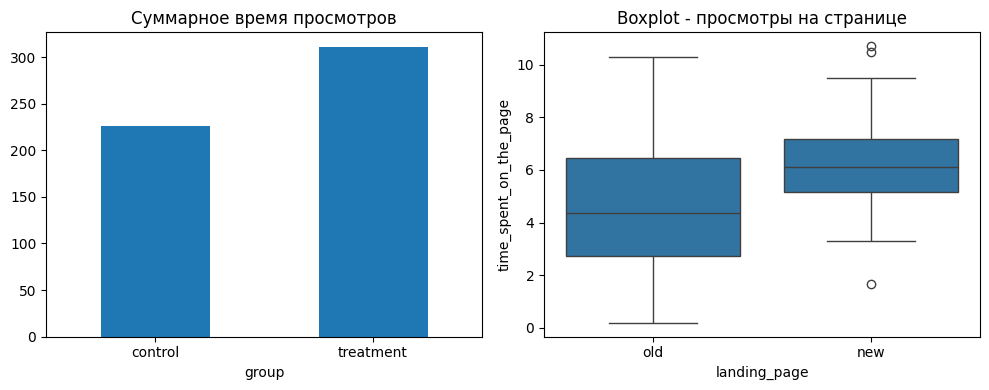

In [ ]:
#сравним суммарное время просмотров на разных версиях сайта

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sum_time.plot.bar(stacked=True)
plt.xticks(rotation=0)
plt.title("Суммарное время просмотров")


plt.subplot(1,2,2)

sns.boxplot(data=df,x='landing_page',y='time_spent_on_the_page')
plt.title(f'Boxplot - просмотры на странице')


plt.tight_layout()

plt.show()

In [ ]:
#считаем какое время провели пользователи на каждой из страничек
sum_time_cntrl = df[df['group'] == 'control'].groupby('Date')['time_spent_on_the_page'].sum()
sum_time_trmt = df[df['group'] == 'treatment'].groupby('Date')['time_spent_on_the_page'].sum()
print(sum_time_cntrl, sum_time_trmt)

Date
2024-11-01    52.47
2024-11-02    69.68
2024-11-03    55.81
2024-11-04    48.66
Name: time_spent_on_the_page, dtype: float64 Date
2024-11-01    75.08
2024-11-02    72.81
2024-11-03    90.08
2024-11-04    73.19
Name: time_spent_on_the_page, dtype: float64


In [ ]:
sum_time_group = pd.concat([sum_time_cntrl, sum_time_trmt], axis=1)
sum_time_group.index = ['01.11.24', '02.11.24', '03.11.24', '04.11.24']


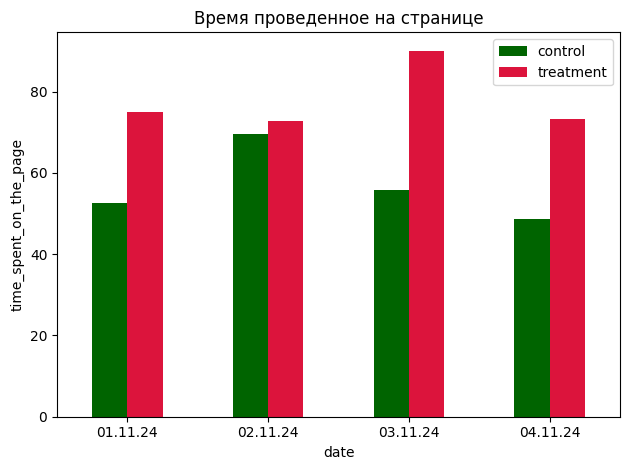

In [ ]:
#строим Bar Plot по дням

n = sum_time_group.plot.bar(rot=0, color=['darkgreen', 'crimson'], title="Время проведенное на странице")
n.set_xlabel('date')
n.set_ylabel('time_spent_on_the_page')
plt.legend(labels=["control","treatment"])

plt.tight_layout()
plt.show()



In [ ]:
df.groupby('landing_page')['time_spent_on_the_page'].mean()

,time_spent_on_the_page
landing_page,
new,6.2232
old,4.5324


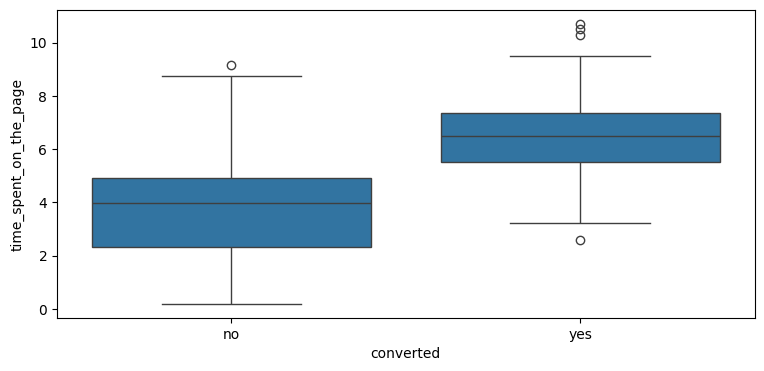

In [ ]:
plt.figure(figsize=(9, 4))
sns.boxplot(data = df, x = 'converted', y = 'time_spent_on_the_page')
plt.show()

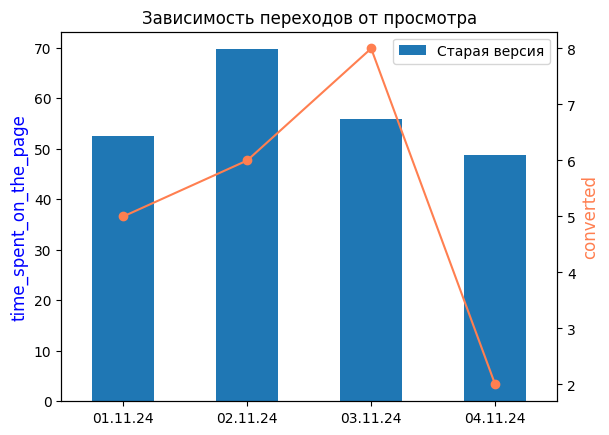

In [ ]:
#исследуем зависимость количества переходов от времени просмотра на старой версии
fig, ax1 = plt.subplots()
sum_time_cntrl = df[df['group'] == 'control'].groupby('Date')['time_spent_on_the_page'].sum()
sum_time = pd.concat([sum_time_cntrl, old_conv_by_day], axis=1)
sum_time.index = ['01.11.24', '02.11.24', '03.11.24', '04.11.24']

one = sum_time['time_spent_on_the_page'].plot(kind="bar", title='Зависимость переходов от просмотра');plt.xticks(rotation=0)
ax1.set_ylabel('time_spent_on_the_page', fontsize=12, color='blue')

ax2 = ax1.twinx()
ax2.plot(one.get_xticks(),sum_time['converted'], marker='o', color='coral')
ax2.set_ylabel('converted', fontsize=12, color='coral')

one.legend(labels=["Старая версия"])
# Display the plot
plt.show()




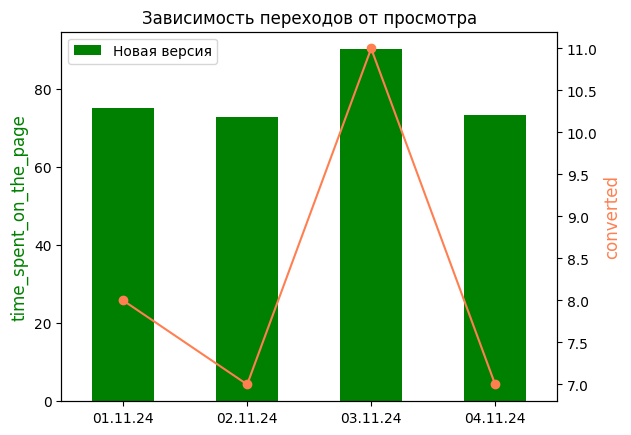

In [ ]:
#исследуем зависимость количества переходов от времени просмотра на новой версии

fig, ax1 = plt.subplots()
sum_time_trtmnt = df[df['group'] == 'treatment'].groupby('Date')['time_spent_on_the_page'].sum()
sum_time = pd.concat([sum_time_trtmnt, new_conv_by_day], axis=1)
sum_time.index = ['01.11.24', '02.11.24', '03.11.24', '04.11.24']

ax = sum_time['time_spent_on_the_page'].plot(kind="bar", title='Зависимость переходов от просмотра', color='green');plt.xticks(rotation=0)
ax1.set_ylabel('time_spent_on_the_page', fontsize=12, color='green')

ax2 = ax1.twinx()
ax2.plot(ax.get_xticks(),sum_time['converted'],marker='o', color='coral')
ax2.set_ylabel('converted', fontsize=12, color='coral')

ax.legend(labels=["Новая версия"])
# Display the plot
plt.show()


In [ ]:
#Формируем конверсии по языку в группах
old_lang_conv = df[mask_old].groupby('language_preferred')['converted'].count()
new_lang_conv = df[mask_new].groupby('language_preferred')['converted'].count()

print(old_lang_conv, new_lang_conv)

language_preferred
English    11
French      3
Spanish     7
Name: converted, dtype: int64 language_preferred
English    10
French     12
Spanish    11
Name: converted, dtype: int64


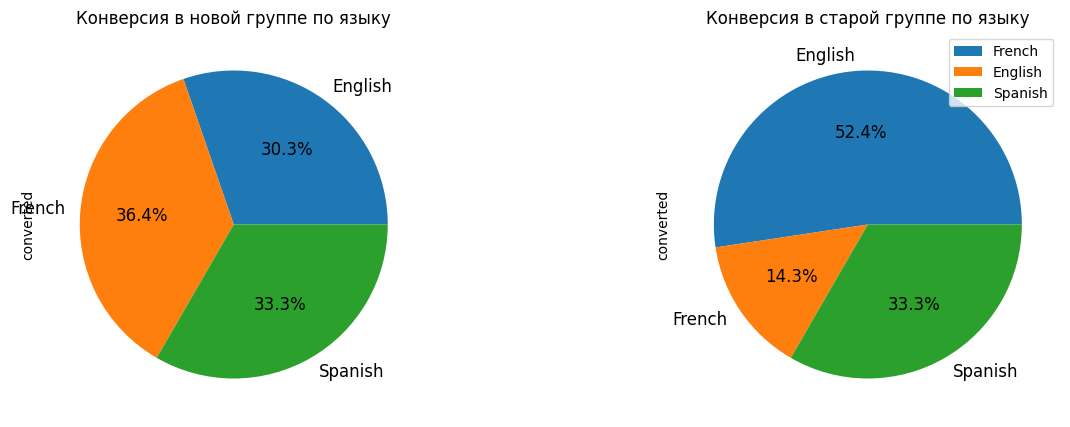

In [ ]:
#Строим круговые диаграммы по распределению языков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

new_lang_conv.plot(x = df['language_preferred'], ax=axes[0], kind='pie', fontsize=12, title="Конверсия в новой группе по языку", autopct='%1.1f%%')
plt.legend(labels=["French", "English", 'Spanish'])


old_lang_conv.plot(x = df['language_preferred'], ax=axes[1], kind='pie', fontsize=12, title="Конверсия в старой группе по языку", autopct='%1.1f%%')
plt.legend(labels=["French", "English", 'Spanish'])


plt.show()

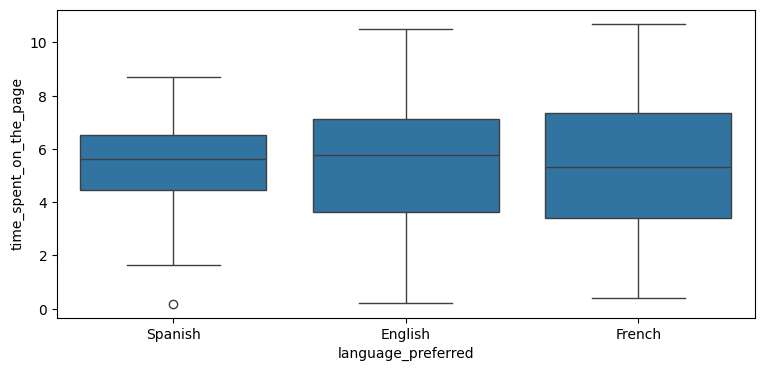

In [ ]:
plt.figure(figsize=(9, 4))
sns.boxplot(data = df, x = 'language_preferred', y = 'time_spent_on_the_page')
plt.show()

In [ ]:
#Формируем конверсии по полу в группах
old_sex_conv = df[mask_old].groupby('sex')['converted'].count()
new_sex_conv = df[mask_new].groupby('sex')['converted'].count()

print(old_sex_conv, new_sex_conv)

sex
man       7
woman    14
Name: converted, dtype: int64 sex
man      15
woman    18
Name: converted, dtype: int64


In [ ]:
#соотношение мужчин и женщин в группах
ct_sex_group = pd.crosstab(df['group'], df['sex'], normalize='index')
ct_sex_group

sex,man,woman
group,,
control,0.44,0.56
treatment,0.46,0.54


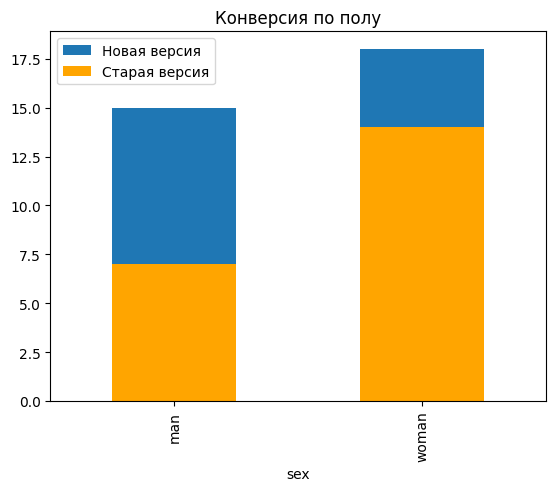

In [ ]:
#строим Stacked Bar Plots на основе пола по конверсии
new_sex_conv.plot(x = df['sex'], y = df['converted'], kind='bar')

old_sex_conv.plot(x = df['sex'], y = df['converted'],kind='bar', title="Конверсия по полу", color='orange')

plt.legend(labels=["Новая версия", "Старая версия"])
plt.show()

In [ ]:
#Формируем конверсии по возрасту в группах
old_age_conv = df[mask_old].groupby('age')['converted'].count()
new_age_conv = df[mask_new].groupby('age')['converted'].count()

print(old_age_conv, new_age_conv)

age
19    2
20    1
22    1
25    1
27    1
28    1
29    3
31    2
33    2
34    2
35    2
36    2
40    1
Name: converted, dtype: int64 age
17    1
18    1
19    3
20    2
21    2
22    1
25    1
27    1
29    3
30    1
32    3
33    1
34    1
35    1
36    2
37    1
38    1
39    1
40    2
43    1
45    2
46    1
Name: converted, dtype: int64


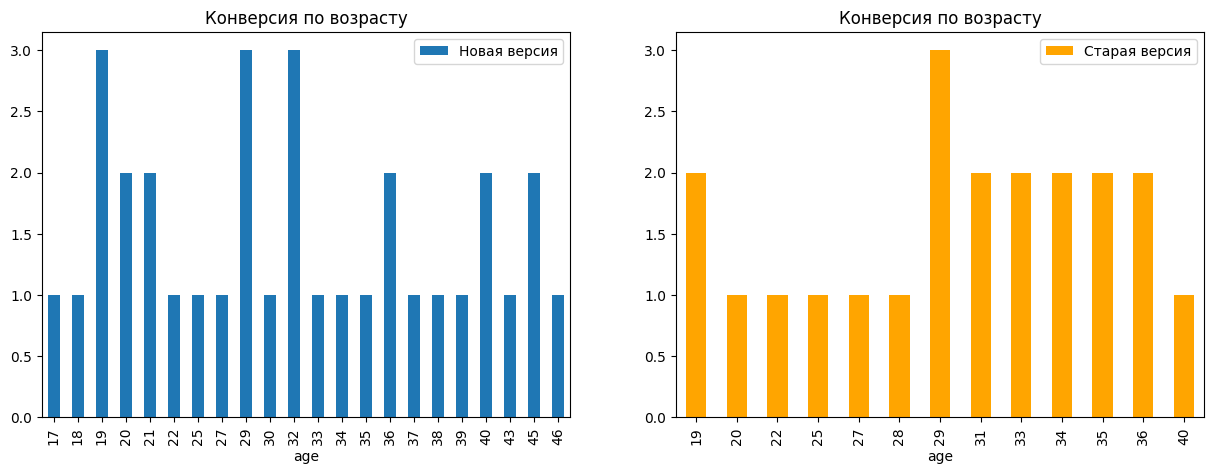

In [ ]:
#строим графики конверсии в группах по возрасту
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

ax = plt.gca()
new_age_conv.plot(x = df['Date'], y = df['converted'],kind='bar', ax=axes[0], title="Конверсия по возрасту")
axes[0].legend(labels=["Новая версия"])
old_age_conv.plot(x = df['Date'], y = df['converted'], kind='bar', ax=axes[1], title="Конверсия по возрасту", color='orange')

ax.legend(labels=["Старая версия"])
plt.show()